<a href="https://colab.research.google.com/github/gerardgoh/bt4222/blob/main/related_fallback_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data

In [21]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import logging
import re
import numpy as np
import pandas as pd
import zipfile
from os import read

In [10]:
!pip install pyarrow

Loading reviews data for EDA

In [37]:
reviews_path = '/content/drive/MyDrive/amazon_data/cleaned_reviews.csv'
cleaned_reviews = pd.read_csv(reviews_path, keep_default_na=False)

Loading cleaned metadata (parquet format) for model

In [27]:
metadata_path = '/content/drive/My Drive/amazon_data/metadata_cleaned.parquet'
cleaned_metadata = pd.read_parquet(metadata_path)
cleaned_metadata= cleaned_metadata.drop(columns=['imUrl','categories','brand','n_categories','impute_source','category_paths']) # drop irrelevant columns
cleaned_metadata.head(10)

,asin,description,title,price,salesRank,related,flattened_categories,granular_category,first_category,also_viewed,also_bought,bought_together,buy_after_viewing
0,0132793040,The Kelby Training DVD Mastering Blend Modes i...,Kelby Training DVD: Mastering Blend Modes in A...,64.99,None,None,Electronics > Computers & Accessories > Cables...,Monitor Accessories,Electronics,[],[],[],[]
1,0321732944,[no description],Kelby Training DVD: Adobe Photoshop CS5 Crash ...,64.99,None,None,Electronics > Computers & Accessories > Cables...,Monitor Accessories,Electronics,[],[],[],[]
2,0439886341,Digital Organizer and Messenger,Digital Organizer and Messenger,8.15,"{'Arts, Crafts & Sewing': None, 'Automotive': ...","{'also_bought': None, 'also_viewed': ['0545016...","Electronics > Computers & Accessories > PDAs, ...",PDAs & Handhelds,Electronics,"[B009ECM8QY, B000N2X2GO, B001CODA9G, B00009MVF...",[],[],[]
3,0511189877,The CLIKR-5 UR5U-8780L remote control is desig...,CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,None,"{'also_bought': None, 'also_viewed': ['B001KC0...",Electronics > Accessories & Supplies > Audio &...,TV Remote Controls,Electronics,"[B003DNS88C, B003YKB3OA, B00KUL8O0W, B003UVVGH...",[],[],"[B0028IKXLS, B001KC08A4, B00KUL8O0W, B000ST9BEO]"
4,0528881469,"Like its award-winning predecessor, the Intell...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,None,"{'also_bought': None, 'also_viewed': ['B006ZOI...",Electronics > GPS & Navigation > Vehicle GPS >...,Trucking GPS,Electronics,"[B00J5AT5DE, B003PJ6R0A, B004NNUDEI, B00BHABL1...",[],[],"[B0090C7A2A, B00C7FKT2A, B006ZOI9OY, B001PBWNOY]"
5,0558835155,Use these high quality headphones for internet...,Polaroid Pbm2200 PC / Gaming Stereo Headphones...,13.95,None,None,Electronics > Accessories & Supplies > Audio &...,Headphones,Electronics,[],[],[],[]
6,0594012015,The Barnes &amp;amp; Noble BNADPN31 Power Kit ...,Barnes &amp; Noble NOOK Power Kit in Carbon BN...,32.10,None,"{'also_bought': ['B0032UP32K', 'B0034ZRAW4', '...",Electronics > eBook Readers & Accessories > Po...,Power Adapters,Electronics,[],"[B0087UBS4M, 140053271X, B004C3KHSG, B004D1OBF...","[B0087UBS4M, B0032UP32K]","[B0087UBS4M, B0032UP32K, B00AZRHYKW, B004C3KHSG]"
7,0594017580,"NOOK cover, designed by Jonathon Adler.\nFits ...",Jonathan Adler Punctuation Cover in Black,78.83,None,"{'also_bought': None, 'also_viewed': ['1616855...",Electronics > eBook Readers & Accessories > Skins,Skins,Electronics,"[161685572X, B00HVRJZII, B00HVRK3B6, B00HVRJVY...",[],[],[140053271X]
8,0594450209,Keep your tablet safe with this Barnes &amp; N...,Barnes &amp; Noble 7&quot; Lautner Chocolate N...,15.55,None,"{'also_bought': None, 'also_viewed': ['1615527...",Electronics > eBook Readers & Accessories > Co...,Covers,Electronics,"[1616826053, 0594450187, 1615527672, 059445025...",[],[],"[1615527672, 161552763X]"
9,0594287995,[no description],Kate Spade Rain or Shine Magazine Cover for No...,14.99,None,None,Electronics > eBook Readers & Accessories > Co...,Covers,Electronics,[],[],[],[]


In [41]:
related_features = related_features = pd.DataFrame({
    'asin': cleaned_metadata['asin'],
    'also_viewed': cleaned_metadata['also_viewed'],
    'also_bought': cleaned_metadata['also_bought'],
    'bought_together': cleaned_metadata['bought_together'],
    'buy_after_viewing': cleaned_metadata['buy_after_viewing']
})

In [59]:
def find_unmatched_related_products(metadata_df, related_features):
    """
    Find ASINs in related product features that do not exist in the main metadata

    Parameters:
    -----------
    metadata_df : pandas DataFrame
        The main metadata DataFrame containing all electronics products
    related_features : pandas DataFrame
        DataFrame containing related product features

    Returns:
    --------
    dict: A dictionary of unmatched ASINs for each related product feature
    """
    # Get the set of ASINs from the main metadata
    metadata_asins = set(metadata_df['asin'])

    # Initialize a dictionary to store unmatched ASINs
    unmatched_asins = {}

    # List of related product features to check
    related_columns = ['also_viewed', 'also_bought', 'bought_together', 'buy_after_viewing']

    # Iterate through each related product feature
    for column in related_columns:
        # Flatten the list of related product ASINs
        all_related_asins = [asin for sublist in related_features[column] for asin in sublist]

        # Find ASINs that are not in the main metadata
        unmatched = set(all_related_asins) - metadata_asins

        # Store the unmatched ASINs
        unmatched_asins[column] = list(unmatched)

    return unmatched_asins


def print_unmatched_summary(unmatched_asins):
    """
    Print a summary of unmatched ASINs

    Parameters:
    -----------
    unmatched_asins : dict
        Dictionary of unmatched ASINs for each related product feature
    """
    print("Unmatched Related Product ASINs Summary:")
    for feature, asins in unmatched_asins.items():
        print(f"\n{feature}:")
        print(f"Total unmatched ASINs: {len(asins)}")

unmatched_related_products = find_unmatched_related_products(cleaned_metadata, related_features)
print_unmatched_summary(unmatched_related_products)

Unmatched Related Product ASINs Summary:

also_viewed:
Total unmatched ASINs: 376449

also_bought:
Total unmatched ASINs: 211123

bought_together:
Total unmatched ASINs: 17257

buy_after_viewing:
Total unmatched ASINs: 69281


Our analysis reveals that there exist products in the related product features (such as 'also_viewed', 'also_bought', 'bought_together', and 'buy_after_viewing') that are not present in our electronics metadata dataset. For the scope of our project, we are unable to recommend these products as we lack their metadata to generate meaningful explanations. Consequently, our recommendation model will require a filter to first verify that recommended products are indeed electronics products with complete metadata, ensuring the quality and relevance of our RAG-powered explanations.

# Analysis of Related Features

From preliminary analysis of each feature, buy_after_viewing is not particularly relevant for recommendations as it seems more reflective of users; browsing behavior than purchase intent and lacks a strong signal for meaningful recommendations. Hence, we will be omitting it from our recommendations.

In [50]:
has_values = (
    (related_features['also_viewed'].apply(len) > 0) &
    (related_features['also_bought'].apply(len) > 0) &
    (related_features['bought_together'].apply(len) > 0)
)
rows_with_all_values = related_features[has_values]

In [51]:
print(rows_with_all_values.head())

            asin                                        also_viewed  \
287   9269807207  [B00D3HBRA4, B009NC0N8K, B009TQ4L5Q, B00AYCTZ3...   
1521  B00000J47F  [B00009QOOO, B00BT2MWF4, B00DSYFAEQ, B0032S1AS...   
1581  B00000J6WY  [B00004TBLW, B000Y26M6U, B00B9Z24J0, B00B7LQ73...   
1793  B00000JGN9  [B001FWXTK0, B000W72MW0, B00164BTMC, B0045KJ0Q...   
2787  B00003IEMD  [B004V2HF92, B00009QOOO, B000N5V9YS, B003D7LHH...   

                                            also_bought  \
287   [B003TRJQ56, B00ATNL9AS, B004M13YI8, B0015H1FA...   
1521  [B00095M8VA, B001FWXTLY, B000BSKOBG, B00339NIN...   
1581  [B00200BVXS, B00E0FZEAC, B00E0G3NRW, B00CTUY0D...   
1793  [B00I0VVQYU, B001FWXTK0, B000W72MW0, B004E3GMX...   
2787  [B00009QOOO, B000N5V9YS, B001OBWGX8, B001KPR6D...   

               bought_together buy_after_viewing  
287               [B009QZH7BU]                []  
1521  [B00339NINQ, B000BESLQK]                []  
1581              [B000051ZOA]                []  
1793          

In [55]:
# Find the row where asin equals 9269807207
target_row = cleaned_metadata[cleaned_metadata['asin'] == '9269807207']

# Check if the row exists
if len(target_row) > 0:
    print("Found row with ASIN 9269807207:")

    # Get the related products from each feature
    also_viewed = target_row['also_viewed'].iloc[0]
    also_bought = target_row['also_bought'].iloc[0]
    bought_together = target_row['bought_together'].iloc[0]

    # Print the title of the main product
    main_product_title = target_row['title'].iloc[0]
    print(f"\nMain Product: {main_product_title}")

    # Function to get product titles
    def get_product_titles(asin_list, max_products=5):
        titles = []
        for asin in asin_list[:max_products]:
            product = cleaned_metadata[cleaned_metadata['asin'] == asin]
            if len(product) > 0:
                titles.append((asin, product['title'].iloc[0]))
            else:
                titles.append((asin, "Title not found"))
        return titles

    # Print product titles for each category (up to 5)
    print("\n--- BOUGHT TOGETHER PRODUCTS (up to 5) ---")
    bought_together_titles = get_product_titles(bought_together)
    for i, (asin, title) in enumerate(bought_together_titles, 1):
        print(f"{i}. ASIN: {asin}")
        print(f"   Title: {title}")

    print("\n--- ALSO BOUGHT PRODUCTS (up to 5) ---")
    also_bought_titles = get_product_titles(also_bought)
    for i, (asin, title) in enumerate(also_bought_titles, 1):
        print(f"{i}. ASIN: {asin}")
        print(f"   Title: {title}")

    print("\n--- ALSO VIEWED PRODUCTS (up to 5) ---")
    also_viewed_titles = get_product_titles(also_viewed)
    for i, (asin, title) in enumerate(also_viewed_titles, 1):
        print(f"{i}. ASIN: {asin}")
        print(f"   Title: {title}")

    # Print counts
    print("\n--- SUMMARY ---")
    print(f"Total products in bought_together: {len(bought_together)}")
    print(f"Total products in also_bought: {len(also_bought)}")
    print(f"Total products in also_viewed: {len(also_viewed)}")

else:
    print("No row found with ASIN 9269807207")

Found row with ASIN 9269807207:

Main Product: HD 720p Dice Mini Camera with Night Vision ***MICRO SD Card NOT INCLUDED***

--- BOUGHT TOGETHER PRODUCTS (up to 5) ---
1. ASIN: B009QZH7BU
   Title: Title not found

--- ALSO BOUGHT PRODUCTS (up to 5) ---
1. ASIN: B003TRJQ56
   Title: Title not found
2. ASIN: B00ATNL9AS
   Title: TOP Secret Spy Camera Mini Clock Radio Hidden DVR- Continuous power or battery
3. ASIN: B004M13YI8
   Title: Title not found
4. ASIN: B0015H1FAG
   Title: Title not found
5. ASIN: B00CGTN2N0
   Title: Mini U8 USB Disk HD Hidden Spy Camera 720x480 Motion Detector Video Recorder USA

--- ALSO VIEWED PRODUCTS (up to 5) ---
1. ASIN: B00D3HBRA4
   Title: 4GB Color Hat Cap Camera Hidden Camera Pinhole Camera Mini DVR with Remote Control
2. ASIN: B009NC0N8K
   Title: Mini Dv 5MP Worlds Smallest HD Digital Video Camera Spy Camera Video Recorder Hidden Cam DV DVR with 1280 x 960 Resolution
3. ASIN: B009TQ4L5Q
   Title: NEW HOT New Smallest Mini Camera Camcorder Video Dv D

# Distribution of relevant related features

In [39]:
for feature in related_features:
    num_empty = (cleaned_metadata[feature].apply(lambda x: len(x)==0)).sum()
    print(f"{feature}: {num_empty} rows are empty")

also_viewed: 303555 rows are empty
also_bought: 352968 rows are empty
bought_together: 353669 rows are empty


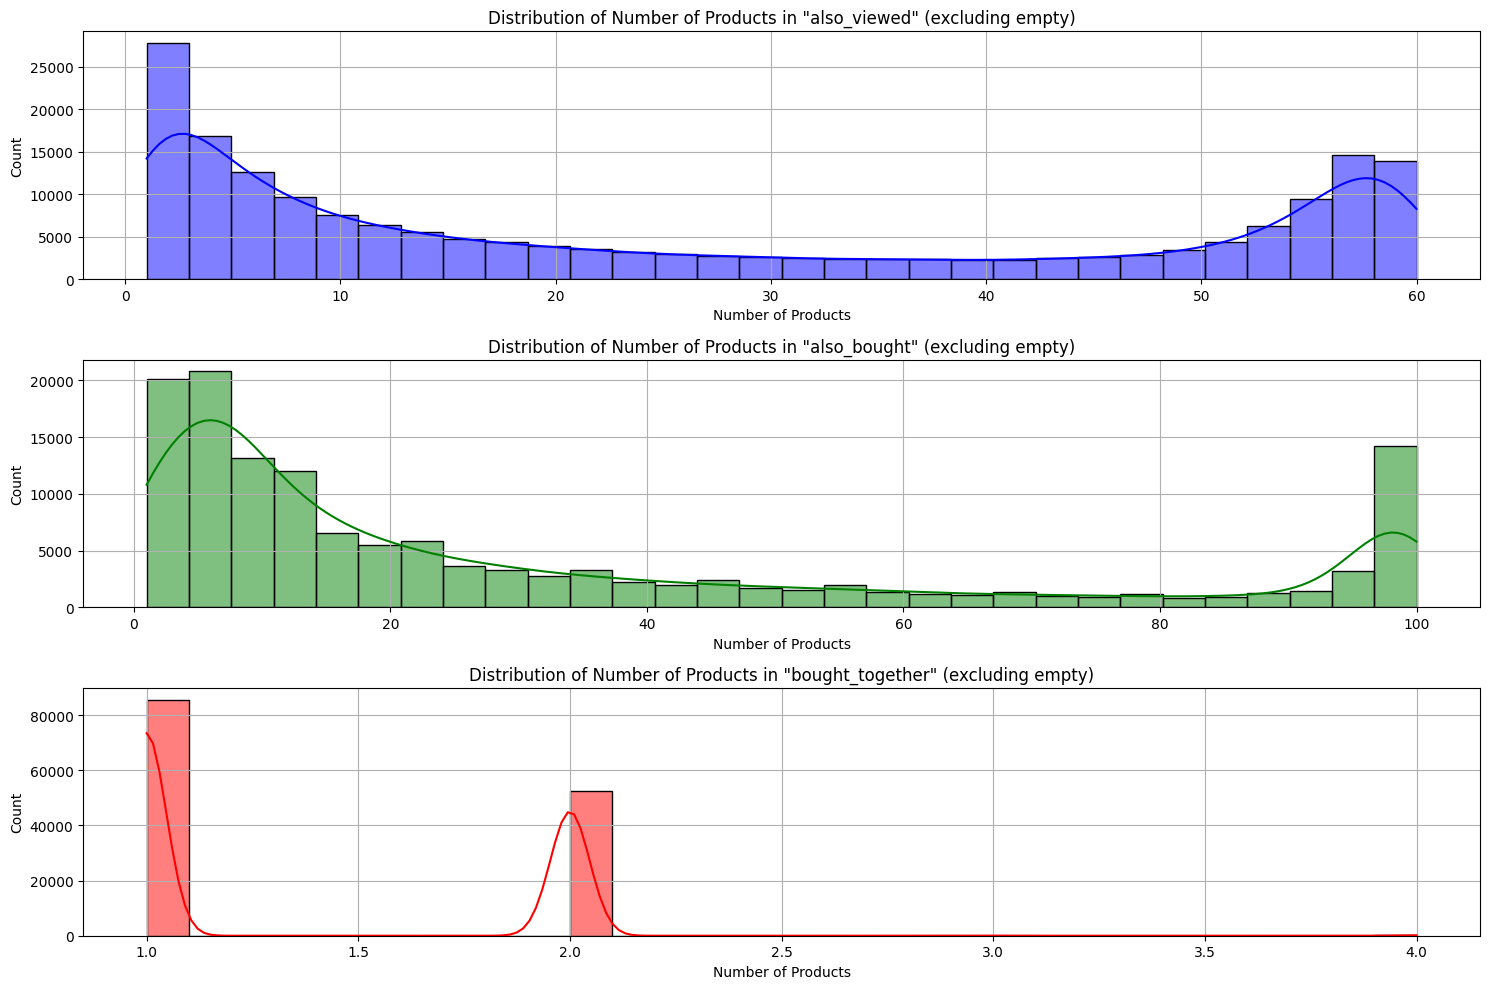

Summary Statistics for 'also_viewed' (excluding empty):
count    188454.000000
mean         25.780641
std          22.102093
min           1.000000
25%           5.000000
50%          18.000000
75%          51.000000
max          60.000000
Name: also_viewed_count, dtype: float64

Summary Statistics for 'also_bought' (excluding empty):
count    139041.000000
mean         31.494955
std          33.051529
min           1.000000
25%           6.000000
50%          16.000000
75%          48.000000
max         100.000000
Name: also_bought_count, dtype: float64

Summary Statistics for 'bought_together' (excluding empty):
count    138340.000000
mean          1.384422
std           0.495806
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: bought_together_count, dtype: float64


<ipython-input-31-fde9d7a39073>:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['also_viewed', 'also_bought', 'bought_together'])


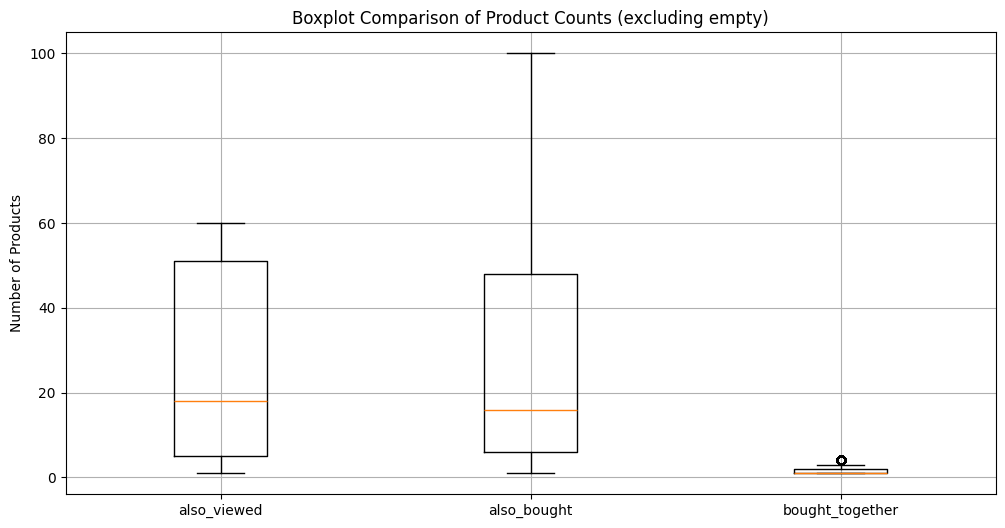

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Calculate the length of each list in the specified columns
cleaned_metadata['also_viewed_count'] = cleaned_metadata['also_viewed'].apply(len)
cleaned_metadata['also_bought_count'] = cleaned_metadata['also_bought'].apply(len)
cleaned_metadata['bought_together_count'] = cleaned_metadata['bought_together'].apply(len)

# Set up the figure for plotting
plt.figure(figsize=(15, 10))

# Plot 1: Distribution of also_viewed
plt.subplot(3, 1, 1)
sns.histplot(cleaned_metadata[cleaned_metadata['also_viewed_count'] > 0]['also_viewed_count'],
             bins=30, kde=True, color='blue')
plt.title('Distribution of Number of Products in "also_viewed" (excluding empty)')
plt.xlabel('Number of Products')
plt.ylabel('Count')
plt.grid(True)

# Plot 2: Distribution of also_bought
plt.subplot(3, 1, 2)
sns.histplot(cleaned_metadata[cleaned_metadata['also_bought_count'] > 0]['also_bought_count'],
             bins=30, kde=True, color='green')
plt.title('Distribution of Number of Products in "also_bought" (excluding empty)')
plt.xlabel('Number of Products')
plt.ylabel('Count')
plt.grid(True)

# Plot 3: Distribution of bought_together
plt.subplot(3, 1, 3)
sns.histplot(cleaned_metadata[cleaned_metadata['bought_together_count'] > 0]['bought_together_count'],
             bins=30, kde=True, color='red')
plt.title('Distribution of Number of Products in "bought_together" (excluding empty)')
plt.xlabel('Number of Products')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate and print summary statistics for each distribution
print("Summary Statistics for 'also_viewed' (excluding empty):")
print(cleaned_metadata[cleaned_metadata['also_viewed_count'] > 0]['also_viewed_count'].describe())

print("\nSummary Statistics for 'also_bought' (excluding empty):")
print(cleaned_metadata[cleaned_metadata['also_bought_count'] > 0]['also_bought_count'].describe())

print("\nSummary Statistics for 'bought_together' (excluding empty):")
print(cleaned_metadata[cleaned_metadata['bought_together_count'] > 0]['bought_together_count'].describe())

# Additional plot: Box plot for comparison
plt.figure(figsize=(12, 6))
data_to_plot = [
    cleaned_metadata[cleaned_metadata['also_viewed_count'] > 0]['also_viewed_count'],
    cleaned_metadata[cleaned_metadata['also_bought_count'] > 0]['also_bought_count'],
    cleaned_metadata[cleaned_metadata['bought_together_count'] > 0]['bought_together_count']
]
plt.boxplot(data_to_plot, labels=['also_viewed', 'also_bought', 'bought_together'])
plt.title('Boxplot Comparison of Product Counts (excluding empty)')
plt.ylabel('Number of Products')
plt.grid(True)
plt.show()

## Distribution Analysis:

**bought_together**: The distribution shows that products in this category predominantly have exactly 1 or 2 items (with no values in between), indicating highly specific product pairings. These represent the strongest signal of product relationships, as they capture items that customers have explicitly purchased together.

**also_bought**: Products in this category show a more diverse distribution, with most products having between 1-20 related products, and some extending up to 100 related items. This represents a moderate signal strength based on purchase behavior.

**also_viewed**: This category shows a bimodal distribution with peaks around 1-5 products and again at approximately 60 products, suggesting browse-based relationships that are more varied but potentially less intentional than purchase data.

The distribution analysis clearly shows that for many products, individual related categories may contain relatively few products per item. This limited availability of recommendations within each category justifies a need for a fill-in approach, where we need to retrieve products from the next strongest signal to fill in our recommendations. This maximizes the value of our data while maintaining recommendation quality through careful prioritization.

# Exploring user clusters


In [48]:
cleaned_reviews.head(10)
# cleaned_reviews  = cleaned_reviews.drop(columns=['reviewerName','helpful','unixReviewTime','reviewTime','helpfulRatio','weighted_helpfulness','recency','truncated_word_count'])

,reviewerID,asin,reviewText,overall,summary,combined_score,clean_reviewText,clean_summary,truncated_review,embedding_input
0,AO94DHGC771SJ,0528881469,We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,0.184925,We got this GPS for my husband who is an (OTR)...,Gotta have GPS!,We got this GPS for my husband who is an (OTR)...,Summary: Gotta have GPS! Review: We got this G...
1,AMO214LNFCEI4,0528881469,"I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,0.506477,"I'm a professional OTR truck driver, and I bou...",Very Disappointed,"I'm a professional OTR truck driver, and I bou...",Summary: Very Disappointed Review: I'm a profe...
2,A3N7T0DY83Y4IG,0528881469,"Well, what can I say. I've had this unit in m...",3.0,1st impression,0.734152,"Well, what can I say. I've had this unit in my...",1st impression,"Well, what can I say. I've had this unit in my...","Summary: 1st impression Review: Well, what can..."
3,A1H8PY3QHMQQA0,0528881469,"Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",0.496846,"Not going to write a long review, even thought...","Great grafics, POOR GPS","Not going to write a long review, even thought...","Summary: Great grafics, POOR GPS Review: Not g..."
4,A24EV6RXELQZ63,0528881469,I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",0.162747,I've had mine for a year and here's what we go...,"Major issues, only excuses for support",I've had mine for a year and here's what we go...,"Summary: Major issues, only excuses for suppor..."
5,A2JXAZZI9PHK9Z,0594451647,I am using this with a Nook HD+. It works as d...,5.0,HDMI Nook adapter cable,0.414523,I am using this with a Nook HD+. It works as d...,HDMI Nook adapter cable,I am using this with a Nook HD+. It works as d...,Summary: HDMI Nook adapter cable Review: I am ...
6,A2P5U7BDKKT7FW,0594451647,The cable is very wobbly and sometimes disconn...,2.0,Cheap proprietary scam,0.196847,The cable is very wobbly and sometimes disconn...,Cheap proprietary scam,The cable is very wobbly and sometimes disconn...,Summary: Cheap proprietary scam Review: The ca...
7,AAZ084UMH8VZ2,0594451647,This adaptor is real easy to setup and use rig...,5.0,A Perfdect Nook HD+ hook up,0.197101,This adaptor is real easy to setup and use rig...,A Perfdect Nook HD+ hook up,This adaptor is real easy to setup and use rig...,Summary: A Perfdect Nook HD+ hook up Review: T...
8,AEZ3CR6BKIROJ,0594451647,This adapter easily connects my Nook HD 7&#34;...,4.0,A nice easy to use accessory.,0.199565,"This adapter easily connects my Nook HD 7"" to ...",A nice easy to use accessory.,"This adapter easily connects my Nook HD 7"" to ...",Summary: A nice easy to use accessory. Review:...
9,A3BY5KCNQZXV5U,0594451647,This product really works great but I found th...,5.0,This works great but read the details...,0.415139,This product really works great but I found th...,This works great but read the details...,This product really works great but I found th...,Summary: This works great but read the details...


## Number of reviews per reviewer

Objective: To check if we can meaningfully segment users based on their review frequency. Users with higher purchase frequencies may exhibit higher interests in complementary products due to their higher spending habits.

count    192403.000000
mean          8.779427
std           8.263942
min           5.000000
25%           5.000000
50%           7.000000
75%           9.000000
max         431.000000
dtype: float64


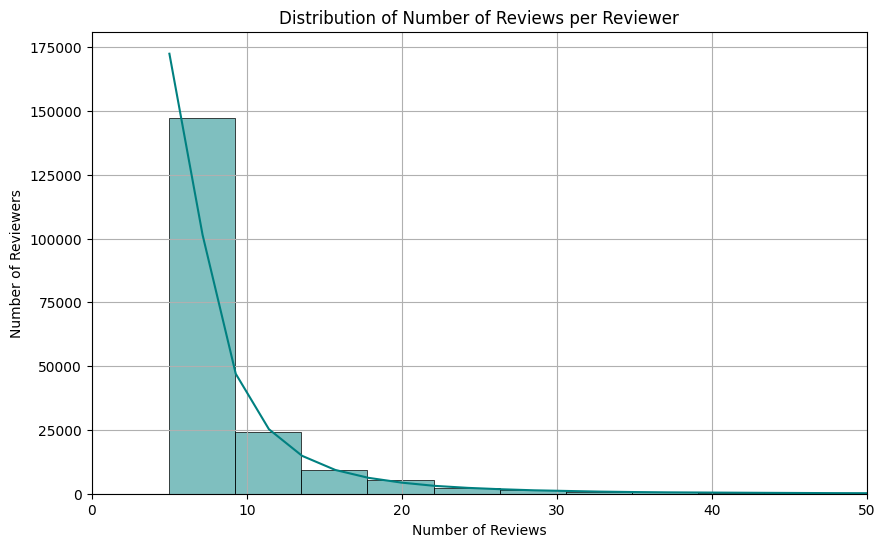

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by reviewerID and count the number of reviews
user_review_counts = cleaned_reviews.groupby('reviewerID').size()

# Basic statistics if you want to print
print(user_review_counts.describe())

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(user_review_counts, bins=100, kde=True, color='teal')
plt.title("Distribution of Number of Reviews per Reviewer")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Reviewers")
plt.xlim(0, 50)  # Optional: zoom in for better view if you have very skewed data
plt.grid(True)
plt.show()


## User's purchase diversity

Object: To check if we can meaningfully segment users based on the diversity of their purchases. Users with higher diversity across their purchases may exhibit higher interests in complementary products.

In [60]:
# Assuming your two DataFrames are:
# cleaned_reviews = your reviews data
# cleaned_metadata = your metadata with 'asin' and 'granular_category'

# # Step 1: Merge the dataframes on 'asin'
merged_reviews = cleaned_reviews.merge(
    cleaned_metadata[['asin', 'granular_category']],
    on='asin',
    how='left'  # Use left join to keep all reviews even if some metadata is missing
)


                       num_unique_categories  num_reviews  \
reviewerID                                                  
A000715434M800HLCENK9                      5            5   
A00101847G3FJTWYGNQA                       6            6   
A00166281YWM98A3SVD55                      4            5   
A0046696382DWIPVIWO0K                      5            5   
A00472881KT6WR48K907X                      7            7   

                       category_diversity_ratio  
reviewerID                                       
A000715434M800HLCENK9                       1.0  
A00101847G3FJTWYGNQA                        1.0  
A00166281YWM98A3SVD55                       0.8  
A0046696382DWIPVIWO0K                       1.0  
A00472881KT6WR48K907X                       1.0  


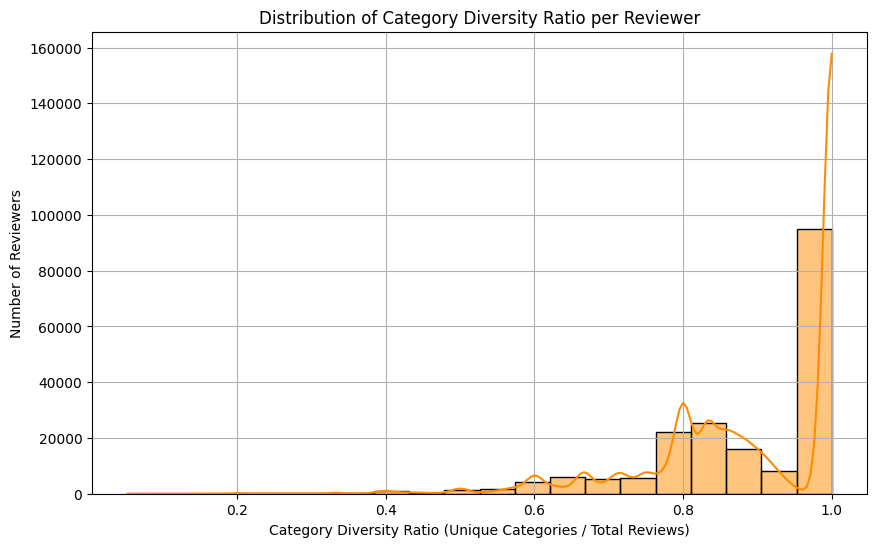

In [55]:
# Step 1: Number of unique categories per reviewer
user_category_diversity = merged_reviews.groupby('reviewerID')['granular_category'].nunique()

# Step 2: Total number of reviews per reviewer
user_review_counts = merged_reviews.groupby('reviewerID').size()

# Step 3: Merge into a single DataFrame
user_stats = pd.DataFrame({
    'num_unique_categories': user_category_diversity,
    'num_reviews': user_review_counts
})

# Step 4: Calculate the fraction
user_stats['category_diversity_ratio'] = user_stats['num_unique_categories'] / user_stats['num_reviews']

# Step 5: Check the result
print(user_stats.head())

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(user_stats['category_diversity_ratio'], bins=20, kde=True, color='darkorange')
plt.title("Distribution of Category Diversity Ratio per Reviewer")
plt.xlabel("Category Diversity Ratio (Unique Categories / Total Reviews)")
plt.ylabel("Number of Reviewers")
plt.grid(True)
plt.show()

From our user analysis, we can see that:
- Most users typically buy a diverse range of electronic products. This is logical, as electronic products typically exhibit a one-time purchase nature, making repeat purchases in the same category limited.

- There is limited segmentation signals based on review frequency as well, as more than 75% of reviewers have less than 10 reviews.


Given these constraints, we determine that it is not meaningful to segment their preferences towards similar or complementary products. Compounded by the sparsity of related electronics data, we further justify using the fill-in strategy that uses a generic recommendation approach that prioritises product discovery of any available similary or complementary products.

# Summary
Our fallback model will start with retreiving 'also bought' products, and then expanding to 'also viewed' and 'bought together' features to address data sparsity. The primary business objective is to maximize catalog exposure, reduce cart abandonment, and encourage customer exploration of diverse products. We deliberately exclude 'buy_after_viewing' as it lacks meaningful recommendation value, appearing more like a browsing alternative than a substantive purchase signal. By prioritizing similar and complementary products with complete metadata, we aim to create a recommendation system that balances precise suggestions with comprehensive product discovery, ultimately driving customer engagement and potential revenue lift.

# Creating the Related Fallback Model

In [61]:
class RelatedFallbackModel:
    def __init__(self, metadata_df):
        """
        Initialize the Related Fallback Model using metadata dataframe

        Parameters:
        -----------
        metadata_df : pandas DataFrame
            The metadata dataframe containing the related product fields
        """
        self.metadata_df = metadata_df
        self.related_features = pd.DataFrame({
            'asin': metadata_df['asin'],
            'also_viewed': metadata_df['also_viewed'],
            'also_bought': metadata_df['also_bought'],
            'bought_together': metadata_df['bought_together'],
        })

        # Set of electronics ASINs for filtering
        self.electronics_asins = set(metadata_df['asin'])

    def is_electronics_product(self, asin):
        """
        Check if a product is an electronics product

        Parameters:
        -----------
        asin : str
            The ASIN of the product to verify

        Returns:
        --------
        bool
            True if the product is in electronics metadata, False otherwise
        """
        return asin in self.electronics_asins

    def get_recommendations(self, product_id, num_recommendations=5):
        """
        Get related product recommendations based on a given product ID

        Parameters:
        -----------
        product_id : str
            The ASIN of the product to get recommendations for
        num_recommendations : int
            Number of recommendations to return (default set at 5)

        Returns:
        --------
        list
            List of recommended product ASINs (filtered to electronics products)
        """
        if product_id not in self.related_features['asin'].values:
            return []

        # Get the related products for the given product ID
        product_row = self.related_features[self.related_features['asin'] == product_id].iloc[0]
        recommendations = []
        remaining_slots = num_recommendations

        # Helper function to filter and add recommendations
        def add_filtered_recommendations(product_list):
            nonlocal recommendations, remaining_slots
            filtered_recs = [
                p for p in product_list
                if p not in recommendations
                and self.is_electronics_product(p)
            ][:remaining_slots]

            recommendations.extend(filtered_recs)
            remaining_slots -= len(filtered_recs)
            return filtered_recs

        # Prioritize recommendations in order: bought_together, also_bought, also_viewed
        if len(product_row['bought_together']) > 0:
            add_filtered_recommendations(product_row['bought_together'])

        # If we still need more recommendations, fill with also_bought
        if remaining_slots > 0 and len(product_row['also_bought']) > 0:
            add_filtered_recommendations(product_row['also_bought'])

        # If we still need more recommendations, fill with also_viewed
        if remaining_slots > 0 and len(product_row['also_viewed']) > 0:
            add_filtered_recommendations(product_row['also_viewed'])

        # Return filtered recommendations (should be at most num_recommendations)
        return recommendations